# Load Data From The Original Source On The Web 

In [1]:
#loading in the library necessary
library(tidyverse)
install.packages("tidyverse")
library(repr)
library(tidymodels)
install.packages("themis")
library(themis)

#formatting
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes     

In [2]:
#loads the data
cleveland <- read_csv("https://raw.githubusercontent.com/JennWan/Group_Project/main/new%20data/newcleveland_data.csv", col_names = F)

print("Table 1: Cleveland Data Set")
cleveland

Rows: 303 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): X2, X3, X6, X7, X9, X11, X12, X13, X14, X15
dbl  (5): X1, X4, X5, X8, X10

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Table 1: Cleveland Data Set"


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
63,male,angina,145,233,true,hyp,150,fal,2.3,down,0.0,fix,buff,H
67,male,asympt,160,286,fal,hyp,108,true,1.5,flat,3.0,norm,sick,S2
67,male,asympt,120,229,fal,hyp,129,true,2.6,flat,2.0,rev,sick,S1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,male,notang,118,149,fal,hyp,126,fal,0.8,up,3.0,norm,sick,S1
74,fem,abnang,120,269,fal,hyp,121,true,0.2,up,1.0,norm,buff,H
54,fem,notang,160,201,fal,norm,163,fal,0.0,up,1.0,norm,buff,H


# Wrangling and Cleaning The Data

In [3]:
#renaming variables for readability 
colnames(cleveland) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                         "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

#selecting predictors of interest
cleveland_tidy <- cleveland |>
                select(age, cp, trestbps, chol, fbs, thalach, exang, ca, thal, num) |>
                mutate(age = as.integer(age), 
                       trestbps = as.integer(trestbps), 
                       chol = as.integer(chol), 
                       thalach = as.integer(thalach), 
                       cp = as_factor(cp), 
                       fbs = as_factor(fbs), 
                       exang = as_factor(exang), 
                       ca = as.integer(ca), 
                       ca = as_factor(ca), 
                       thal = as_factor(thal), 
                       num = as_factor(num)) |>
                filter(!is.na(ca), !is.na(thal))

print("Table 2: Tidy Cleveland Data Set")
cleveland_tidy

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `ca = as.integer(ca)`.
Caused by warning:
! NAs introduced by coercion”


[1] "Table 2: Tidy Cleveland Data Set"


age,cp,trestbps,chol,fbs,thalach,exang,ca,thal,num
<int>,<fct>,<int>,<int>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>
63,angina,145,233,true,150,fal,0,fix,buff
67,asympt,160,286,fal,108,true,3,norm,sick
67,asympt,120,229,fal,129,true,2,rev,sick
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
49,notang,118,149,fal,126,fal,3,norm,sick
74,abnang,120,269,fal,121,true,1,norm,buff
54,notang,160,201,fal,163,fal,1,norm,buff


In [4]:
# find the mean values of numerical variables in our data set to discuss the effects of preprocessing

mean_table <- cleveland_tidy |>
    mutate(mean_age = mean(age), 
          mean_trestbps = mean(trestbps), 
          mean_chol = mean(chol), 
          mean_thalach = mean(thalach)) |>
    select(mean_age, mean_trestbps, mean_chol, mean_thalach) |>
    slice(1)

print("Table 3: Mean Values of Numerical Variables")
mean_table

[1] "Table 3: Mean Values of Numerical Variables"


mean_age,mean_trestbps,mean_chol,mean_thalach
<dbl>,<dbl>,<dbl>,<dbl>
54.51007,131.5805,246.906,149.4664


In [5]:
# find the number and percentage of differing presence of heart disease observations in our data set
# to check for class imbalance

print("Table 4: Counts of Buff vs Sick Observations")
num_obs <- nrow(cleveland_tidy)
    cleveland_tidy |>
    group_by(num) |>
    summarize(
        count = n(),
        percentage = n() / num_obs * 100)

[1] "Table 4: Counts of Buff vs Sick Observations"


num,count,percentage
<fct>,<int>,<dbl>
buff,161,54.02685
sick,137,45.97315


In [6]:
# center, scaling and balancing the heart disease data
cleve_recipe <- recipe(num ~ ., data = cleveland_tidy) |>
    step_scale(trestbps, chol, thalach) |>
    step_center(trestbps, chol, thalach) |>
    step_upsample(num, over_ratio = 1, skip = FALSE) |>
    prep()

preprocessed_cleve <- bake(cleve_recipe, cleveland_tidy)

print("Table 5: Preprocessed Cleveland Data Set")
preprocessed_cleve

[1] "Table 5: Preprocessed Cleveland Data Set"


age,cp,trestbps,chol,fbs,thalach,exang,ca,thal,num
<int>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,angina,0.75947933,-0.2679748,true,0.02321445,fal,0,fix,buff
37,notang,-0.08945105,0.0596218,fal,1.63304188,fal,0,norm,buff
41,abnang,-0.08945105,-0.8268160,fal,0.98040914,fal,0,norm,buff
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,abnang,-1.2213582,-0.3450563,fal,0.8063737,fal,0,rev,sick
50,asympt,0.7028840,-0.9038975,fal,-1.0209979,true,0,rev,sick
58,asympt,-0.2026418,0.2330553,fal,-0.8469625,true,2,rev,sick


In [7]:
# find the number and percentage of differing presence of heart disease observations in our data set
# double check class imbalance

print("Table 6: Preprocessed Counts of Buff vs Sick Observations")
num_obs <- nrow(preprocessed_cleve)
    preprocessed_cleve |>
    group_by(num) |>
    summarize(
        count = n(),
        percentage = n() / num_obs * 100)

[1] "Table 6: Preprocessed Counts of Buff vs Sick Observations"


num,count,percentage
<fct>,<int>,<dbl>
buff,161,50
sick,161,50


In [8]:
# create the TRAIN SET and TEST SET
set.seed(2000)

cleveland_split <- initial_split(preprocessed_cleve, prop = 0.75, strata = num)
cleveland_train <- training(cleveland_split) 
cleveland_test <- testing(cleveland_split)

print("Table 7: Training Cleveland Data Set")
cleveland_train

print("Table 8: Testing Cleveland Data Set")
cleveland_test

[1] "Table 7: Training Cleveland Data Set"


age,cp,trestbps,chol,fbs,thalach,exang,ca,thal,num
<int>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
63,angina,0.75947933,-0.2679748,true,0.02321445,fal,0,fix,buff
37,notang,-0.08945105,0.0596218,fal,1.63304188,fal,0,norm,buff
41,abnang,-0.08945105,-0.8268160,fal,0.98040914,fal,0,norm,buff
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
61,asympt,0.3633118,-1.5590906,fal,-1.0645068,true,1,norm,sick
48,abnang,-1.2213582,-0.3450563,fal,0.8063737,fal,0,rev,sick
50,asympt,0.7028840,-0.9038975,fal,-1.0209979,true,0,rev,sick


[1] "Table 8: Testing Cleveland Data Set"


age,cp,trestbps,chol,fbs,thalach,exang,ca,thal,num
<int>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
44,abnang,-0.65540464,0.3101368,fal,1.0239180,fal,0,rev,buff
49,abnang,-0.08945105,0.3679480,fal,0.9369003,fal,0,norm,buff
58,angina,1.04245612,0.6955445,true,0.5453206,fal,0,norm,buff
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
60,asympt,0.4765025,0.88824839,fal,0.8933914,fal,2,rev,sick
59,asympt,2.4007447,0.04035141,fal,-0.2813475,true,0,norm,sick
58,asympt,-0.2026418,0.23305527,fal,-0.8469625,true,2,rev,sick


## Exploration of Model Predictors

In [9]:
# create tbl to compare the average_age for each stage of heart disease presence and arrange by average_age
exploration_tbl1 <- cleveland_train |>
    group_by(num) |>
    summarize(avg_age = mean(age)) |>
    arrange(avg_age)

print("Exploration Table 1: Average Age Between Buff vs Sick Observations")
exploration_tbl1

[1] "Exploration Table 1: Average Age Between Buff vs Sick Observations"


num,avg_age
<fct>,<dbl>
buff,52.675
sick,57.400


In [10]:
# create tbl to compare average_trestbps (resting blood pressure in mm Hg on admission to the hospital) for each stage of heart disease presence and arrange by average_trestbps
exploration_tbl2 <- cleveland_train |>
    group_by(num) |>
    summarize(avg_trestbps = mean(trestbps)) |>
    arrange(avg_trestbps)

print("Exploration Table 2: Title")
exploration_tbl2

[1] "Exploration Table 2: Title"


num,avg_trestbps
<fct>,<dbl>
buff,-0.12765292
sick,0.08457967


In [11]:
# create tbl to compare average_chol for each stage of heart disease presence and arrange by average_colestoral
exploration_tbl3 <- cleveland_train |>
    group_by(num) |>
    summarize(avg_chol = mean(chol)) |>
    arrange(avg_chol)

print("Exploration Table 3: Title")
exploration_tbl3

[1] "Exploration Table 3: Title"


num,avg_chol
<fct>,<dbl>
sick,-0.009912178
buff,0.008555275


In [12]:
# create tbl to compare average_thalach (maximum heart rate achieved) for each stage of heart disease presence and arrange by average_thalach
exploration_tbl4 <- cleveland_train |>
    group_by(num) |>
    summarize(avg_max_heartrate = mean(thalach)) |>
    arrange(avg_max_heartrate)

print("Exploration Table 4: Title")
exploration_tbl4

[1] "Exploration Table 4: Title"


num,avg_max_heartrate
<fct>,<dbl>
sick,-0.3904822
buff,0.4343731


In [13]:
# create tbl to compare the most often occuring cp for each stage of heart disease presence
exploration_tbl5 <- cleveland_train |>
    group_by(num, cp) |>
    summarize(count_cp = n()) |>
    arrange(desc(count_cp)) |>
    head(2)

print("Exploration Table 5: Title")
exploration_tbl5

`summarise()` has grouped output by 'num'. You can override using the `.groups`
argument.


[1] "Exploration Table 5: Title"


num,cp,count_cp
<fct>,<fct>,<int>
sick,asympt,82
buff,notang,46


In [14]:
# create tbl to compare the most often occuring fbs (fasting blood sugar < 120 mg/dl) for each stage of heart disease presence
exploration_tbl6 <- cleveland_train |>
    group_by(num, fbs) |>
    summarize(count_fbs = n()) |>
    arrange(desc(count_fbs)) |>
    head(2)

print("Exploration Table 6: Title")
exploration_tbl6

`summarise()` has grouped output by 'num'. You can override using the `.groups`
argument.


[1] "Exploration Table 6: Title"


num,fbs,count_fbs
<fct>,<fct>,<int>
sick,fal,104
buff,fal,103


In [15]:
# create tbl to compare the most often occuring exang (exercise induced angina) for each stage of heart disease presence
exploration_tbl7 <- cleveland_train |>
    group_by(num, exang) |>
    summarize(count_exang = n()) |>
    arrange(desc(count_exang)) |>
    head(2)

print("Exploration Table 7: Title")
exploration_tbl7

`summarise()` has grouped output by 'num'. You can override using the `.groups`
argument.


[1] "Exploration Table 7: Title"


num,exang,count_exang
<fct>,<fct>,<int>
buff,fal,102
sick,fal,66


In [16]:
# create tbl to compare the most often occuring ca (number of major vessels (0-3) colored by flourosopy) for each stage of heart disease presence
exploration_tbl8 <- cleveland_train |>
    group_by(num, ca) |>
    summarize(count_ca = n()) |>
    arrange(desc(count_ca)) |>
    head(2)

print("Exploration Table 8: Title")
exploration_tbl8

`summarise()` has grouped output by 'num'. You can override using the `.groups`
argument.


[1] "Exploration Table 8: Title"


num,ca,count_ca
<fct>,<fct>,<int>
buff,0,95
sick,2,39


In [17]:
# create tbl to compare the most often occuring thal (thalassemia: a type of blood disorder) for each stage of heart disease presence
exploration_tbl9 <- cleveland_train |>
    group_by(num, thal) |>
    summarize(count_thal = n()) |>
    arrange(desc(count_thal)) |>
    head(2)

print("Exploration Table 9: Title")
exploration_tbl9

`summarise()` has grouped output by 'num'. You can override using the `.groups`
argument.


[1] "Exploration Table 9: Title"


num,thal,count_thal
<fct>,<fct>,<int>
buff,norm,93
sick,rev,72


[1] "Exploration Plot 1: Title"


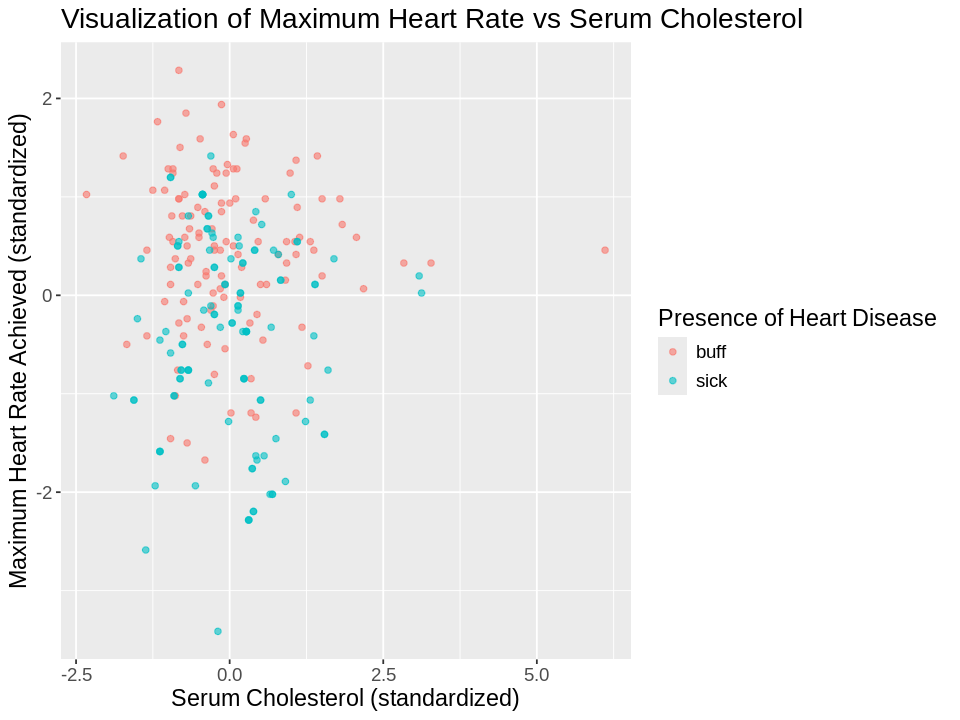

In [18]:
# draw a scatter plot to visualize the relationship between the chol and thalach predictors/variables

options(repr.plot.height = 6, repr.plot.width = 8)
exploration_plot1 <- cleveland_train |>
  ggplot(aes(x = chol, y = thalach, color = num)) +
  geom_point(alpha = 0.6) +
  labs(x = "Serum Cholesterol (standardized)",
       y = "Maximum Heart Rate Achieved (standardized)",
       color = "Presence of Heart Disease", 
       title = "Visualization of Maximum Heart Rate vs Serum Cholesterol") + 
  theme(text = element_text(size = 14))

print("Exploration Plot 1: Title")
exploration_plot1

[1] "Exploration Plot 2: Title"


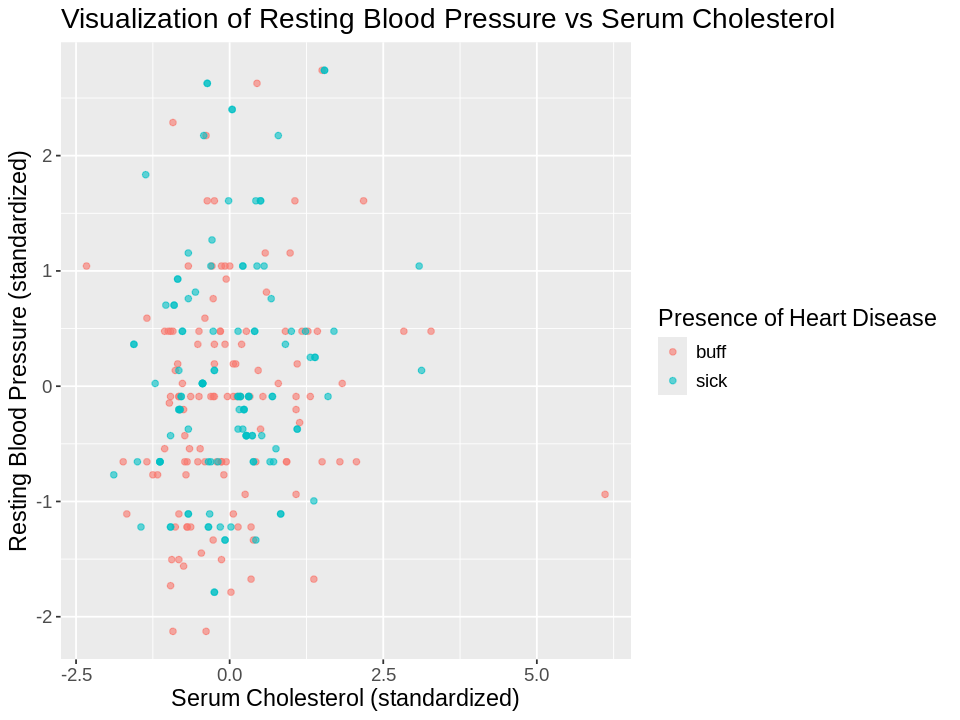

In [19]:
# draw a scatter plot to visualize the relationship between the col and trestbps predictors/variables

options(repr.plot.height = 6, repr.plot.width = 8)
exploration_plot2 <- cleveland_train |>
  ggplot(aes(x = chol, y = trestbps, color = num)) +
  geom_point(alpha = 0.6) +
  labs(x = "Serum Cholesterol (standardized)",
       y = "Resting Blood Pressure (standardized)",
       color = "Presence of Heart Disease", 
       title = "Visualization of Resting Blood Pressure vs Serum Cholesterol") + 
  theme(text = element_text(size = 14))

print("Exploration Plot 2: Title")
exploration_plot2

[1] "Exploration Plot 3: Title"


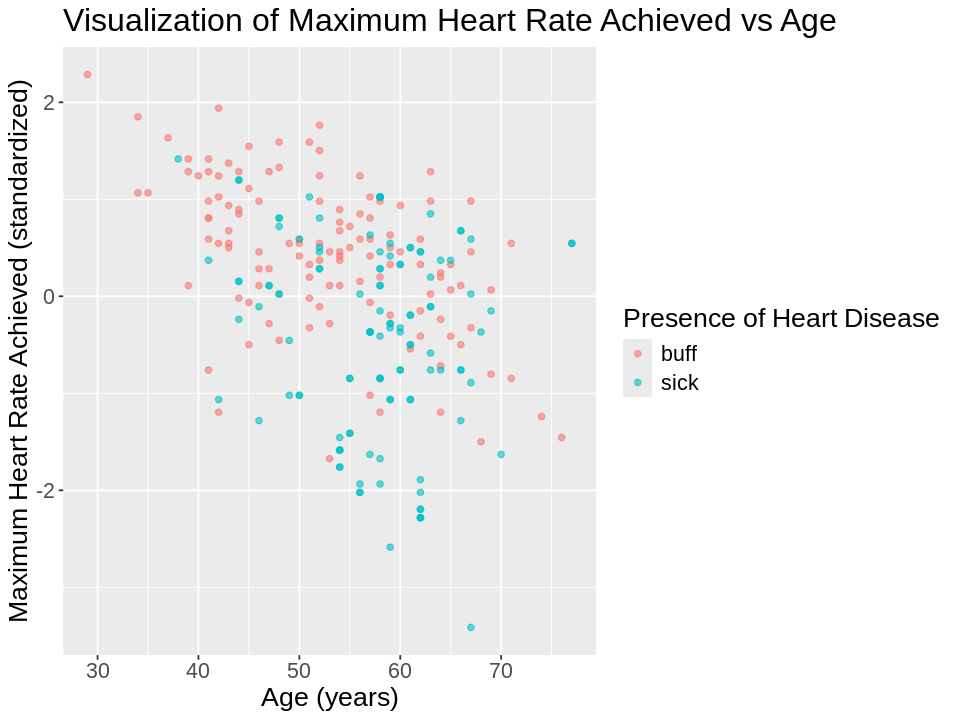

In [20]:
# draw a scatter plot to visualize the relationship between the age and thalach (maximum heart rate achieved) predictors/variables

options(repr.plot.height = 6, repr.plot.width = 8)
exploration_plot3 <- cleveland_train |>
  ggplot(aes(x = age, y = thalach, color = num)) +
  geom_point(alpha = 0.6) +
  labs(x = "Age (years)",
       y = "Maximum Heart Rate Achieved (standardized)",
       color = "Presence of Heart Disease", 
       title = "Visualization of Maximum Heart Rate Achieved vs Age") + 
  theme(text = element_text(size = 16))

print("Exploration Plot 3: Title")
exploration_plot3

## Predictor Exploration Analysis
*/Our tables are relevant in assisting our analysis towards answering our question, as it demonstrates the possible relationship between each predictor and our class. Where within all the tables one in particular clearly demonstrates that there are some positive relationship between the predictor age and num, the presence of heart disease.

Our plots help visually protray further relationship between more variables, whereas there is no clear relationship observed.

To conclude, within the previous tables and plots there does not seem to be any obvious relationship other than the positive relationship between age and the presence of heart disease. It is oberved that between age and the presence of heart disease, num, there is a moderately positive linear relationship where the increase of age has a correlationing increase in the presence of heart disease./*

# Data Analysis

In [21]:
print("Data Analysis Table 1: Training Cleveland Data Set")
cleveland_train <- cleveland_train |> select(cp, chol, trestbps, thalach, exang, thal, num)
cleveland_train

[1] "Data Analysis Table 1: Training Cleveland Data Set"


cp,chol,trestbps,thalach,exang,thal,num
<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
angina,-0.2679748,0.75947933,0.02321445,fal,fix,buff
notang,0.0596218,-0.08945105,1.63304188,fal,norm,buff
abnang,-0.8268160,-0.08945105,0.98040914,fal,norm,buff
⋮,⋮,⋮,⋮,⋮,⋮,⋮
asympt,-1.5590906,0.3633118,-1.0645068,true,norm,sick
abnang,-0.3450563,-1.2213582,0.8063737,fal,rev,sick
asympt,-0.9038975,0.7028840,-1.0209979,true,rev,sick


In [22]:
print("Data Analysis Table 2: Testing Cleveland Data Set")
cleveland_test <- cleveland_test |> select(cp, chol, trestbps, thalach, exang, thal, num)
cleveland_test

[1] "Data Analysis Table 2: Testing Cleveland Data Set"


cp,chol,trestbps,thalach,exang,thal,num
<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
abnang,0.3101368,-0.65540464,1.0239180,fal,rev,buff
abnang,0.3679480,-0.08945105,0.9369003,fal,norm,buff
angina,0.6955445,1.04245612,0.5453206,fal,norm,buff
⋮,⋮,⋮,⋮,⋮,⋮,⋮
asympt,0.88824839,0.4765025,0.8933914,fal,rev,sick
asympt,0.04035141,2.4007447,-0.2813475,true,norm,sick
asympt,0.23305527,-0.2026418,-0.8469625,true,rev,sick


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
36,accuracy,binary,0.7880486,7,0.02254472,Preprocessor1_Model08
16,accuracy,binary,0.7878151,7,0.02564402,Preprocessor1_Model04
26,accuracy,binary,0.7875817,7,0.02174755,Preprocessor1_Model06
⋮,⋮,⋮,⋮,⋮,⋮,⋮
71,accuracy,binary,0.7497666,7,0.02811993,Preprocessor1_Model15
6,accuracy,binary,0.7294585,7,0.01676940,Preprocessor1_Model02
1,accuracy,binary,0.6879085,7,0.02590195,Preprocessor1_Model01


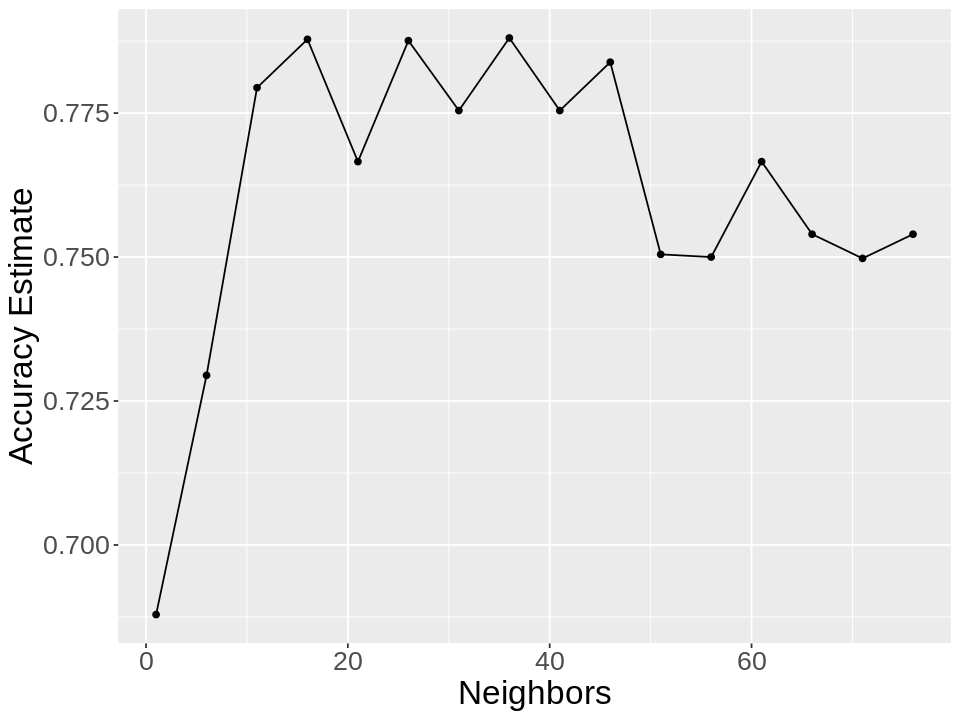

In [23]:
# find the best k neighbour value to use with V-fold cross validation
cleveland_vfold <- vfold_cv(cleveland_train, v = 7, strata = num)

cleveland_recipe <- recipe(num ~ ., data = cleveland_train) |>
    step_scale(trestbps, chol, thalach) |>
    step_center(trestbps, chol, thalach) |>
    step_upsample(num, over_ratio = 1, skip = T) |>
    prep()

cleveland_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

gridvals = tibble(neighbors = seq(from = 1, to = 80, by = 5))

set.seed(2000)

cleveland_results <- workflow() |>
            add_recipe(cleveland_recipe) |>
            add_model(cleveland_spec) |>
            tune_grid(resamples = cleveland_vfold, grid = gridvals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") |>
            arrange(desc(mean))
cleveland_results

# plot k values against their respective accuracies and choose optimal k value
cross_val_plot <- cleveland_results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 20))
cross_val_plot

In [24]:
# compare the accuracy of predictions to the true values in the test set

cleveland_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 66) |>
    set_engine("kknn") |>
    set_mode("classification")

cleveland_fit <- workflow() |>
  add_recipe(cleveland_recipe) |>
  add_model(cleveland_best_spec) |>
  fit(data = cleveland_train)

cleveland_predictions <- predict(cleveland_fit, cleveland_test) |> 
    bind_cols(cleveland_test)

cleveland_acc <- cleveland_predictions |> 
    metrics(truth = num, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)
cleveland_acc

cleveland_cm <- cleveland_predictions |> 
    conf_mat(truth = num, estimate = .pred_class)
cleveland_cm

.metric,.estimate
<chr>,<dbl>
accuracy,0.7926829


          Truth
Prediction buff sick
      buff   37   13
      sick    4   28

accuracy = number of correct predictions/total number of predictions *100%
precision = number of correct positive predictions/total number of positive predictions
recall = number of correct positive predictions/total number of test set observations

In [25]:
#calculate accuracy
accuracy <- (37 + 30)/(37 + 11 + 4 + 30)
accuracy

#note: we wish to predict sick observations; sick is our positive prediction
#calculate precision
precision <- 30/(30 + 4)
precision

#calculate recall
recall <- 30/(30 + 11)
recall

[1] 0.8170732

[1] 0.8823529

[1] 0.7317073

### Work Cited
Marateb HR, Goudarzi S. A noninvasive method for coronary artery diseases diagnosis using a clinically-interpretable fuzzy rule-based system. J Res Med Sci. 2015 Mar;20(3):214-23. PMID: 26109965; PMCID: PMC4468223.